In [1]:
import os

# Install Spark and Java
!apt-get update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!pip install hyperas

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import itertools

# from __future__ import print_function
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.callbacks import EarlyStopping
from keras import regularizers

from hyperopt import Trials, STATUS_OK, tpe
from hyperas import optim
from hyperas.distributions import choice,uniform
import numpy as np


# Set Environment Variables
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

from google.colab import drive
drive.mount('/content/drive')

os.chdir('drive/My Drive/Colab Notebooks/ml-image')
os.listdir()

Hit:1 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:2 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:3 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:4 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Hit:5 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:6 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Hit:7 http://security.ubuntu.com/ubuntu bionic-security InRelease
Ign:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:9 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:10 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:11 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Reading package lists... Done
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/

['frog.jpeg', 'saved_models']

In [2]:
batch_size = 64  # The default batch size of keras.
num_classes = 10  # Number of class for the dataset
epochs = 150
data_augmentation = False

In [3]:
# The data, split between train and test sets:
(X_train, y_train), (x_test, y_test) = cifar10.load_data()
print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)
print(X_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')


X_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 1)
50000 train samples
10000 test samples


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


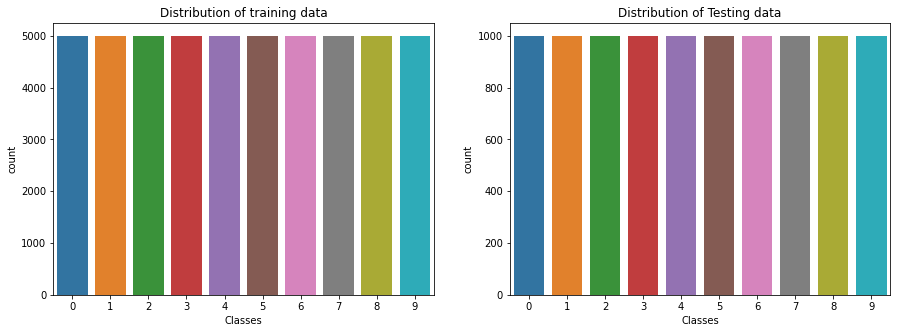

In [4]:
fig, axs = plt.subplots(1,2,figsize=(15,5)) 
# Count plot for training set
sns.countplot(y_train.ravel(), ax=axs[0])
axs[0].set_title('Distribution of training data')
axs[0].set_xlabel('Classes')
# Count plot for testing set
sns.countplot(y_test.ravel(), ax=axs[1])
axs[1].set_title('Distribution of Testing data')
axs[1].set_xlabel('Classes')
plt.show()

In [5]:
# Normalize the data. Before we need to connvert data type to float for computation.
X_train = X_train.astype('float32')
x_test = x_test.astype('float32')
X_train /= 255
x_test /= 255

# Convert class vectors to binary class matrices. This is called one hot encoding.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [6]:
weight_decay = 0.0005
train=True
x_shape = X_train.shape[1:]
x_shape

(32, 32, 3)

In [7]:
model = Sequential()
weight_decay = weight_decay

model.add(Conv2D(64, (3, 3), padding='same',
                 input_shape=x_shape,kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Conv2D(64, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Conv2D(128, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Conv2D(256, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(512,kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 64)        1792      
_________________________________________________________________
activation (Activation)      (None, 32, 32, 64)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 64)        256       
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 64)        2

In [8]:
# initiate RMSprop optimizer
opt = keras.optimizers.RMSprop(learning_rate=0.0001, decay=1e-6)


# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              # optimizer={{choice(['rmsprop', 'adam', 'sgd'])}},
              optimizer=opt,
              metrics=['accuracy'])


In [9]:
callback = EarlyStopping(monitor='val_loss', patience=5)

history = model.fit(X_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              verbose=2,
              validation_data=(x_test, y_test),
              shuffle=True,
              callbacks = [callback])

Epoch 1/150
782/782 - 13s - loss: 4.1444 - accuracy: 0.2349 - val_loss: 4.2252 - val_accuracy: 0.2154
Epoch 2/150
782/782 - 12s - loss: 3.3436 - accuracy: 0.3790 - val_loss: 4.2925 - val_accuracy: 0.3509
Epoch 3/150
782/782 - 12s - loss: 2.8807 - accuracy: 0.4902 - val_loss: 6.3395 - val_accuracy: 0.4426
Epoch 4/150
782/782 - 12s - loss: 2.5318 - accuracy: 0.5813 - val_loss: 4.9913 - val_accuracy: 0.4865
Epoch 5/150
782/782 - 12s - loss: 2.2564 - accuracy: 0.6441 - val_loss: 3.3235 - val_accuracy: 0.5958
Epoch 6/150
782/782 - 12s - loss: 2.0177 - accuracy: 0.6948 - val_loss: 2.2326 - val_accuracy: 0.6908
Epoch 7/150
782/782 - 12s - loss: 1.8377 - accuracy: 0.7281 - val_loss: 1.9432 - val_accuracy: 0.7274
Epoch 8/150
782/782 - 12s - loss: 1.6845 - accuracy: 0.7560 - val_loss: 1.9826 - val_accuracy: 0.7252
Epoch 9/150
782/782 - 12s - loss: 1.5588 - accuracy: 0.7796 - val_loss: 2.0485 - val_accuracy: 0.7098
Epoch 10/150
782/782 - 12s - loss: 1.4531 - accuracy: 0.7963 - val_loss: 1.5974 - 

In [10]:
# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=2)

# make prediction.
pred = model.predict(x_test)

313/313 - 1s - loss: 1.1650 - accuracy: 0.8399


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


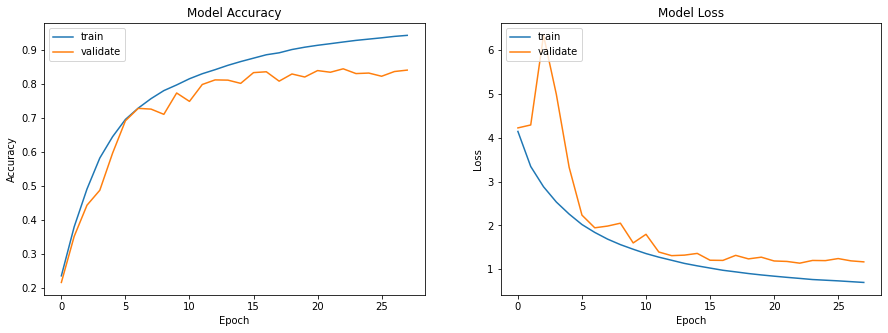

In [11]:
def plotmodelhistory(history): 
    fig, axs = plt.subplots(1,2,figsize=(15,5)) 
    # summarize history for accuracy
    axs[0].plot(history.history['accuracy']) 
    axs[0].plot(history.history['val_accuracy']) 
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy') 
    axs[0].set_xlabel('Epoch')
    axs[0].legend(['train', 'validate'], loc='upper left')
    # summarize history for loss
    axs[1].plot(history.history['loss']) 
    axs[1].plot(history.history['val_loss']) 
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss') 
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['train', 'validate'], loc='upper left')
    plt.show()

# list all data in history
print(history.history.keys())

plotmodelhistory(history)


In [12]:
# # Score trained model.
# scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

# # make prediction.
# pred = model.predict(x_test)

Test loss: 1.1650220155715942
Test accuracy: 0.839900016784668


In [13]:
def heatmap(data, row_labels, col_labels, ax=None, cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.
    """
    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)
    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)
    
    ax.set_xlabel('Predicted Label') 
    ax.set_ylabel('True Label')
    
    return im, cbar

def annotate_heatmap(im, data=None, fmt="d", threshold=None):
    """
    A function to annotate a heatmap.
    """
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            text = im.axes.text(j, i, format(data[i, j], fmt), horizontalalignment="center",
                                 color="white" if data[i, j] > thresh else "black")
            texts.append(text)

    return texts

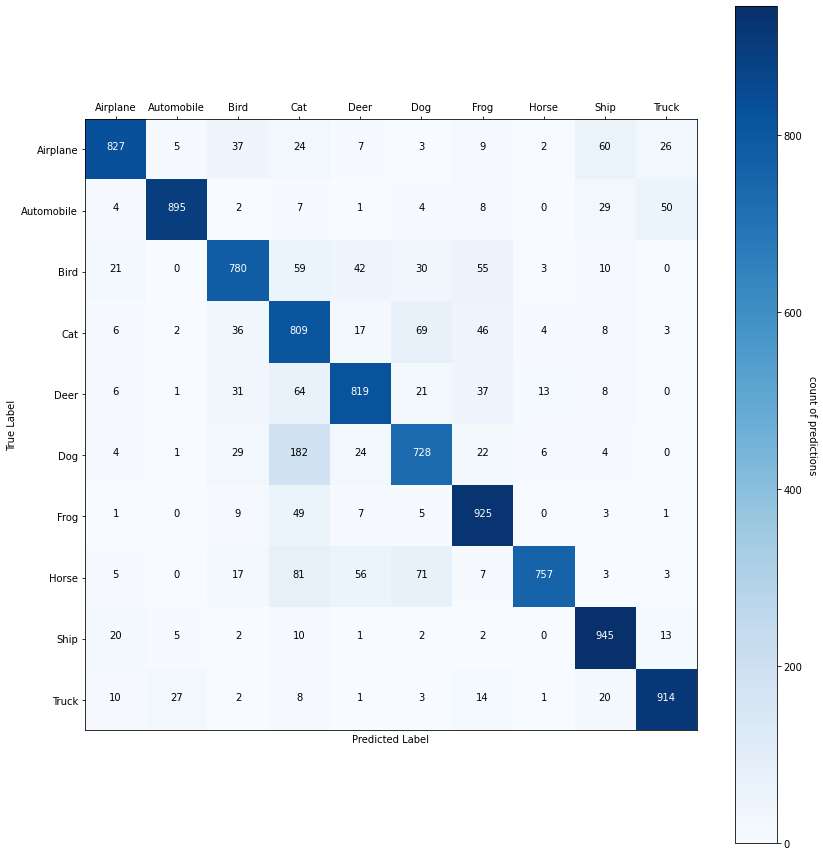

In [14]:
labels = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(pred, axis=1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test, axis=1)
# Errors are difference between predicted labels and true labels
errors = (Y_pred_classes - Y_true != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = pred[errors]
Y_true_errors = Y_true[errors]
X_test_errors = x_test[errors]

cm = confusion_matrix(Y_true, Y_pred_classes) 
thresh = cm.max() / 2.

fig, ax = plt.subplots(figsize=(12,12))
im, cbar = heatmap(cm, labels, labels, ax=ax,
                   cmap=plt.cm.Blues, cbarlabel="count of predictions")
texts = annotate_heatmap(im, data=cm, threshold=thresh)

fig.tight_layout()
plt.show()

In [15]:
print(classification_report(Y_true, Y_pred_classes))

              precision    recall  f1-score   support

           0       0.91      0.83      0.87      1000
           1       0.96      0.90      0.92      1000
           2       0.83      0.78      0.80      1000
           3       0.63      0.81      0.71      1000
           4       0.84      0.82      0.83      1000
           5       0.78      0.73      0.75      1000
           6       0.82      0.93      0.87      1000
           7       0.96      0.76      0.85      1000
           8       0.87      0.94      0.90      1000
           9       0.90      0.91      0.91      1000

    accuracy                           0.84     10000
   macro avg       0.85      0.84      0.84     10000
weighted avg       0.85      0.84      0.84     10000



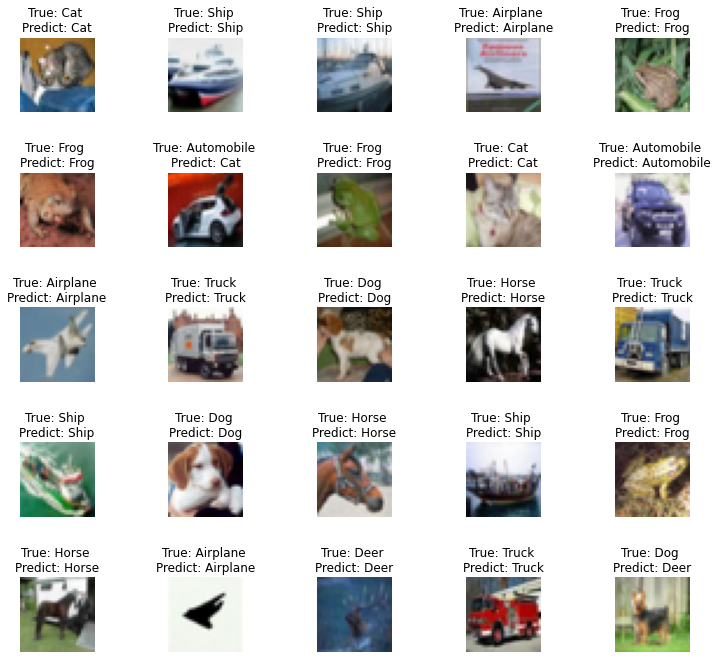

In [16]:
R = 5
C = 5
fig, axes = plt.subplots(R, C, figsize=(12,12))
axes = axes.ravel()

for i in np.arange(0, R*C):
    axes[i].imshow(x_test[i])
    axes[i].set_title("True: %s \nPredict: %s" % (labels[Y_true[i]], labels[Y_pred_classes[i]]))
    axes[i].axis('off')
    plt.subplots_adjust(wspace=1)

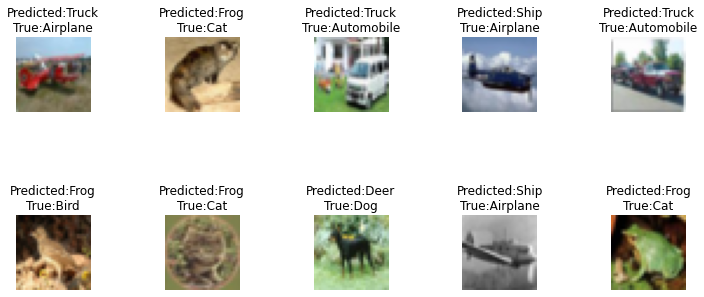

In [17]:
def display_errors(errors_index, img_errors, pred_errors, obs_errors):
    """ This function shows 10 images with their predicted and real labels"""
    n = 0
    nrows = 2
    ncols = 5
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True, figsize=(12,6))
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((32,32,3)))
            ax[row,col].set_title("Predicted:{}\nTrue:{}".
                                  format(labels[pred_errors[error]],labels[obs_errors[error]]))
            n += 1
            ax[row,col].axis('off')
            plt.subplots_adjust(wspace=1)

# Probabilities of the wrong predicted numbers
Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# Top 10 errors 
most_important_errors = sorted_dela_errors[-10:]

# Show the top 10 errors
display_errors(most_important_errors, X_test_errors, Y_pred_classes_errors, Y_true_errors)

In [18]:
def show_test(number):
    fig = plt.figure(figsize = (3,3))
    test_image = np.expand_dims(x_test[number], axis=0)
    test_result = model.predict_classes(test_image)
    plt.imshow(x_test[number])
    dict_key = test_result[0]
    plt.title("Predicted: {} \nTrue Label: {}".format(labels[dict_key],
                                                      labels[Y_true[number]]))

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


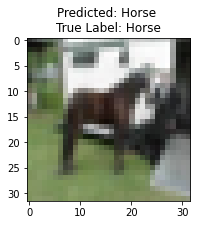

In [19]:
show_test(20)

In [20]:


save_dir = os.path.join(os.getcwd())
model_name = 'Vgg13_model.h5'

# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Saved trained model at /content/drive/My Drive/Colab Notebooks/ml-image/Vgg13_model.h5 
313/313 [==============================] - 1s 5ms/step - loss: 1.1650 - accuracy: 0.8399
Test loss: 1.1650220155715942
Test accuracy: 0.839900016784668
